[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/efurlanm/418/blob/master/pchip-quadrature-burgers.ipynb)

# PCHIP Interpolation

*Last edited 2023-05-26*

Piecewise cubic interpolation (PCHIP) using the solution of the 1D Burgers equation as a toy problem. This work is based on:
- [Piecewise Cubic Hermite Interpolating Polynomial (MathLab PCHIP)](https://www.mathworks.com/help/matlab/ref/pchip.html) - The piecewise cubic interpolation with shape preservation takes the same form as the piecewise cubic Hermite interpolation, but with the first derivatives defined in a special way. This method ensures that the interpolant value stays within the range of the local data points, that is, the new function values do not exceed the function values at the end of each range [1].
- [Burkardt's Gauss-Hermite Quadrature (GHQ)](https://people.sc.fsu.edu/~jburkardt/py_src/burgers_solution/burgers_solution.py) - A Gaussian quadrature form for approximating integral values. The solution of the Burgers equation use estimated values calculated using [Gauss-Hermite's quadrature rule](https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature), as described in the [Basdevant et al. article](https://www.academia.edu/19081708/Spectral_and_finite_difference_solutions_of_the_Burgers_equation). The dataset generated is similar to that used by [Raissi](https://github.com/maziarraissi/PINNs/blob/master/appendix/Data/burgers_shock.mat) and other authors, and allows for an eventual comparison of results. The GHQ method is used to generate the points that will be interpolated, and also to compare the results.

## Table of Contents

The table of contents is automatically generated by JupyterLab or Google Colab.

## Shape-preserving piecewise cubic interpolation (PCHIP)

According to Roberts [1], the shape-preserving piecewise cubic interpolation is similar to piecewise cubic Hermite interpolation, differing in the first derivatives $d_k$ at nodes $(x_k , y_k) \ k = 1, . . . n$ which are specially defined in such a way as to ensure that the function values do not exceed the function values at the end of each interval. The first divided difference is given by

$$\displaystyle \delta_k = \frac{y_{k+1}-y_k}{x_{k+1}-x_k} $$

When the intervals between the data points are all of the same length, the derivative is given by the *harmonic mean* of the two differences $\delta_k$ and $\delta_{k−1}$ at the inner points $(x_k , y_k ), \ k = 2, . . . n − 1$

$$\displaystyle \frac{1}{d_k} = \frac{1}{2} ( \frac{1}{\delta_{k+1}} + \frac{1}{\delta_k} ) $$

If $\delta_k$ and $\delta_{k−1}$ have different signs or if one is zero, it means that $(x_k , y_k)$ will be a stationary point, so we define $d_k = 0$. 

If $\delta_k$ and $\delta_{k−1}$ have the same sign, but the intervals do not have the same lengths, then $d_k$ is given by the *weighted harmonic mean*

$$\displaystyle \frac{w_1 + w_2}{d_k} = \frac{w_1}{\delta_{k-1}} + \frac{w_2}{\delta_k} $$

with weights $w_1 = 2 k_k + h_{k-1}$, $w_2 = k_k + 2 h_{k-1}$

where $h_k = x_{k+1} - x_k$, $h_{k-1} = x_k - x_{k-1}$

A different non-centered form preserving the 3-point formula is used to define the derivatives at the endpoints $(x_1, y_1)$ and $(x_n , y_n)$.

PCHIP is also called Fritsch-Carlson interpolation [4].

The PCHIP implementation used in this work uses an implementation similar to that of Matlab, which is the SciPy library "PCHIP 1-D Monotonic Cubic Interpolator" that also uses algorithms from Fritsch-Butland (1984) [4] and Moeler (2004) [5]. https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.PchipInterpolator.html#scipy.interpolate.PchipInterpolator .

## Burgers' equation

The Burgers equation is a fundamental differential equation used in various areas of applied mathematics, including fluid mechanics, acoustic, gas dynamics and traffic flow [2]. It can be derived from the Navier-Stokes equations for the speed field, reducing the term of the pressure gradient. When viscosity parameters uses small values, the burgers equation can lead to the formation of shocks that is notoriously difficult to solve by classic numerical methods [3].

## GHQ code

This code is an adaptation of [J. Burkardt's work](https://people.sc.fsu.edu/~jburkardt/py_src/burgers_solution/burgers_solution.py) (please follow this link for more information).

### burgers_viscous_time_exact

Evaluates a solution to the Burgers equation. The form of the Burgers equation considered here is

$$\displaystyle \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} $$


for -1.0 < $x$ < +1.0, and 0 < $t$

Initial conditions are $u(x, 0) = - \sin(\pi x)$.  Boundary conditions are $u(-1, t) = u(+1, t) = 0$ . The viscosity parameter $\nu$ is taken to be $\frac{0.01}{\pi}$, although this is not essential. The authors note an integral representation for the solution $u(x, t)$, and present a better version of the formula that is amenable to approximation using Hermite quadrature. This program library does little more than evaluate the exact solution at a user-specified set of points, using the quadrature rule. The order of the quadrature rule can be changed for greater accuracy.

Input:

- real NU ($\nu$), the viscosity
- integer VXN, the number of spatial grid points
- real VX(VXN), the spatial grid points
- integer VTN, the number of time grid points
- real VT(VTN), the time grid points
- qn, the quadrature order

Output:

- real VU(VXN,VTN), the solution of the Burgers equation at each space and time grid point

In [1]:
def burgers_viscous_time_exact(nu, vxn, vx, vtn, vt, qn):
    import numpy as np

    qx, qw = hermite_ek_compute(qn)
    #  Evaluate U(X,T) for later times.
    vu = np.zeros([vxn, vtn])
    for vti in range(0, vtn):
        if (vt[vti] == 0.0):
            for i in range(0, vxn):
                vu[i, vti] = -np.sin(np.pi * vx[i])
        else:
            for vxi in range(0, vxn):
                top = 0.0
                bot = 0.0
                for qi in range(0, qn):
                    c = 2.0 * np.sqrt(nu * vt[vti])
                    top = top - qw[qi] * c * np.sin(np.pi * (vx[vxi] - c * qx[qi])) \
                        * np.exp(- np.cos(np.pi * (vx[vxi] - c * qx[qi]))
                                 / (2.0 * np.pi * nu))
                    bot = bot + qw[qi] * c \
                        * np.exp(- np.cos(np.pi * (vx[vxi] - c * qx[qi]))
                                 / (2.0 * np.pi * nu))
                    vu[vxi, vti] = top / bot
    return vu

### hermite_ek_compute

Computes a Gauss-Hermite quadrature rule. The code uses an algorithm by Elhay and Kautsky. The abscissas are the zeros of the N-th order Hermite polynomial. The integral and the quadrature rule is given by

$$\displaystyle \int_{-\infty}^{+\infty} e^{-x^2} f(x) dx \ \approx \sum_{i=1}^nw_i f(x_i)$$

Input:

- integer N, the number of abscissas

Output:

- real X(N), the abscissas
- real W(N), the weights

In [2]:
def hermite_ek_compute(n):
    from scipy.special import gamma
    import numpy as np

    #  Define the zero-th moment.
    zemu = gamma(0.5)
    #  Define the Jacobi matrix.
    bj = np.zeros(n)
    for i in range(0, n):
        bj[i] = np.sqrt(float(i + 1) / 2.0)
    x = np.zeros(n)
    w = np.zeros(n)
    w[0] = np.sqrt(zemu)
    #  Diagonalize the Jacobi matrix.
    x, w = imtqlx(n, x, bj, w)
    #  If N is odd, force the center X to be exactly 0.
    if (n % 2) == 1:
        x[(n - 1) // 2] = 0.0
    for i in range(0, n):
        w[i] = w[i]**2
    return x, w

### imtqlx

Diagonalizes a symmetric tridiagonal matrix.

Input:

- integer N, the order of the matrix
- real D(N), the diagonal entries of the matrix
- real E(N), the subdiagonal entries of the matrix, in entries E(1) through E(N-1)
- real Z(N), a vector to be operated on

Output:
- real LAM(N), the diagonal entries of the diagonalized matrix
- real QTZ(N), the value of Q' * Z, where Q is the matrix that diagonalizes the input symmetric tridiagonal matrix

In [3]:
def imtqlx(n, d, e, z):
    import numpy as np

    lam = np.zeros(n)
    for i in range(0, n):
        lam[i] = d[i]
    qtz = np.zeros(n)
    for i in range(0, n):
        qtz[i] = z[i]
    if n == 1:
        return lam, qtz
    itn = 30
    epsilon = np.finfo(float).eps
    e[n - 1] = 0.0
    for l in range(1, n + 1):
        j = 0
        while True:
            for m in range(l, n + 1):
                if m == n:
                    break
                if abs(e[m - 1]) <= epsilon * (abs(lam[m - 1]) + abs(lam[m])):
                    break
            p = lam[l - 1]
            if m == l:
                break
            if itn <= j:
                print("")
                print("imtqlx - Fatal error!")
                print("  Iteration limit exceeded.")
                raise Exception("imtqlx - Fatal error!")
            j = j + 1
            g = (lam[l] - p) / (2.0 * e[l - 1])
            r = np.sqrt(g * g + 1.0)
            if g < 0.0:
                t = g - r
            else:
                t = g + r
            g = lam[m - 1] - p + e[l - 1] / (g + t)
            s = 1.0
            c = 1.0
            p = 0.0
            mml = m - l
            for ii in range(1, mml + 1):
                i = m - ii
                f = s * e[i - 1]
                b = c * e[i - 1]
                if abs(g) <= abs(f):
                    c = g / f
                    r = np.sqrt(c * c + 1.0)
                    e[i] = f * r
                    s = 1.0 / r
                    c = c * s
                else:
                    s = f / g
                    r = np.sqrt(s * s + 1.0)
                    e[i] = g * r
                    c = 1.0 / r
                    s = s * c
                g = lam[i] - p
                r = (lam[i - 1] - g) * s + 2.0 * c * b
                p = s * r
                lam[i] = g + p
                g = c * r - b
                f = qtz[i]
                qtz[i] = s * qtz[i - 1] + c * f
                qtz[i - 1] = c * qtz[i - 1] - s * f
            lam[l - 1] = lam[l - 1] - p
            e[l - 1] = g
            e[m - 1] = 0.0
    for ii in range(2, n + 1):
        i = ii - 1
        k = i
        p = lam[i - 1]
        for j in range(ii, n + 1):
            if lam[j - 1] < p:
                k = j
                p = lam[j - 1]
        if k != i:
            lam[k - 1] = lam[i - 1]
            lam[i - 1] = p
            p = qtz[i - 1]
            qtz[i - 1] = qtz[k - 1]
            qtz[k - 1] = p
    return lam, qtz

## Generation of *observation* data using GHQ

The following code generates 10 points $u(t,x)$ using the GHQ method and Burgers' 1D equation. These points will later be used as input points for the PCHIP interpolator.

In [4]:
import numpy as np

vtn = 10  # NT : Time t
vxn = 10  # NX : Variable x
nu = 0.01 / np.pi  # Viscosity
qn = 50  # Quadrature order

xlo = -1.0
xhi = +1.0
vx = np.linspace(xlo, xhi, vxn)

tlo = 0.0
thi = 0.99  # other option: thi = 3.0 / np.pi
vt = np.linspace(tlo, thi, vtn)

vu = burgers_viscous_time_exact(nu, vxn, vx, vtn, vt, qn).T

Save the data:

In [5]:
np.savetxt("burgers_solution_x.csv", vx, delimiter=",")
np.savetxt("burgers_solution_t.csv", vt, delimiter=",")
np.savetxt("burgers_solution_u.csv", vu, delimiter=",")

The data can be loaded, if desired:

In [10]:
# vx = np.loadtxt('burgers_solution_x.csv', delimiter=",")
# vt = np.loadtxt('burgers_solution_t.csv', delimiter=",")
# vu = np.loadtxt('burgers_solution_u.csv', delimiter=",")

In [75]:
vu.shape

(10, 10)

In [38]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [138]:
def graph():
    font = {'size': 'large', 'color': 'green'}
    gs = gridspec.GridSpec(1, 2, wspace=.5)

    ax = plt.subplot(gs[0, 0])
    ax.plot(vx, vu[2, :], '--o')
    ax.set_title(f"t = {vt[2]} s", verticalalignment='bottom', **font)
    ax.set_xlabel('x', **font)
    ax.set_ylabel('u(t,x)', **font)

    ax = plt.subplot(gs[0, 1])
    ax.plot(vx, vu[7, :], '--o')
    ax.set_title(f"t = {vt[7]} s", verticalalignment='bottom', **font)
    ax.set_xlabel('x', **font)
    ax.set_ylabel('u(t,x)', **font)
    ax.set_ylim([-1, 1])

    plt.show()

Plot the 10 "observation points" at two instants of time:

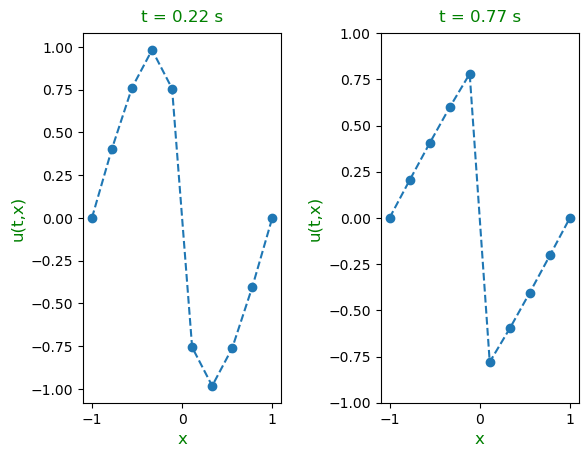

In [139]:
graph()

## Interpolation of the observation data using PCHIP

The observed data (10 points) were generated in the code above, using GHQ.

In [14]:
from scipy.interpolate import pchip_interpolate

t = 0.22 s  :

In [43]:
vt[2]

0.22

xq = query points. The points specified in xq are the x-coordinates for the interpolated function values yq computed by pchip :

In [127]:
x_observed = vx
y_observed = vu[2, :]
xq = np.linspace(min(x_observed), max(x_observed), num=100)
yq = pchip_interpolate(x_observed, y_observed, xq)

t = 0.77 s :

In [128]:
vt[7]

0.77

In [129]:
x_observed2 = vx
y_observed2 = vu[7, :]
xq2 = np.linspace(min(x_observed2), max(x_observed2), num=100)
yq2 = pchip_interpolate(x_observed2, y_observed2, xq)

Shows two graphs side by side, one for t = 0.22 s, and the other for t = 0.77 s :

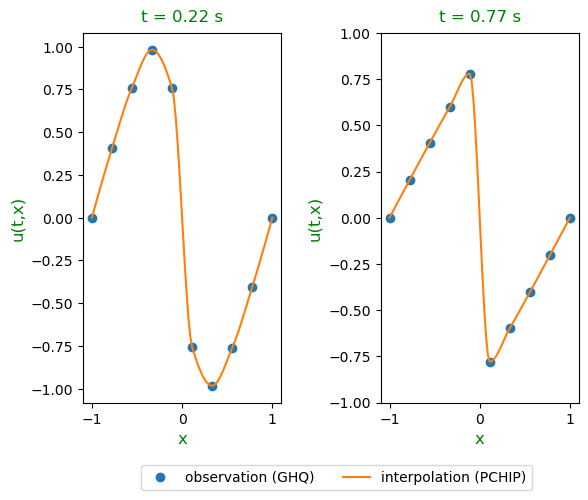

In [148]:
font = {'size': 'large', 'color': 'green'}
gs = gridspec.GridSpec(1, 2, wspace=.5)

ax = plt.subplot(gs[0, 0])
ax.plot(vx, vu[2, :], "o", label="observation (GHQ)")
ax.plot(xq, yq, label="interpolation (PCHIP)")
ax.set_title(f"t = {vt[2]} s", verticalalignment='bottom', **font)
ax.set_xlabel('x', **font)
ax.set_ylabel('u(t,x)', **font)

ax = plt.subplot(gs[0, 1])
plt.plot(vx, vu[7, :], "o", label="observation (GHQ)")
plt.plot(xq2, yq2, label="interpolation (PCHIP)")
ax.set_title(f"t = {vt[7]} s", verticalalignment='bottom', **font)
ax.set_xlabel('x', **font)
ax.set_ylabel('u(t,x)', **font)
ax.set_ylim([-1, 1])

ax.legend(bbox_to_anchor=(0.8, -0.15), ncol=2)
plt.show()

# 1D Burgers solution using GHQ

Generates a database containing 100 points from the solution of the 1D Burgers equation using the GHQ method. It will be used to compare with PCHIP interpolation.

In [48]:
vtn2 = 100  # NT : Time t
vxn2 = 100  # NX : Variable x
nu = 0.01 / np.pi  # Viscosity
qn = 50  # Quadrature order

xlo = -1.0
xhi = +1.0
vx2 = np.linspace(xlo, xhi, vxn2)

tlo = 0.0
thi = 0.99  # other option: thi = 3.0 / np.pi
vt2 = np.linspace(tlo, thi, vtn2)

vu2 = burgers_viscous_time_exact(nu, vxn2, vx2, vtn2, vt2, qn).T

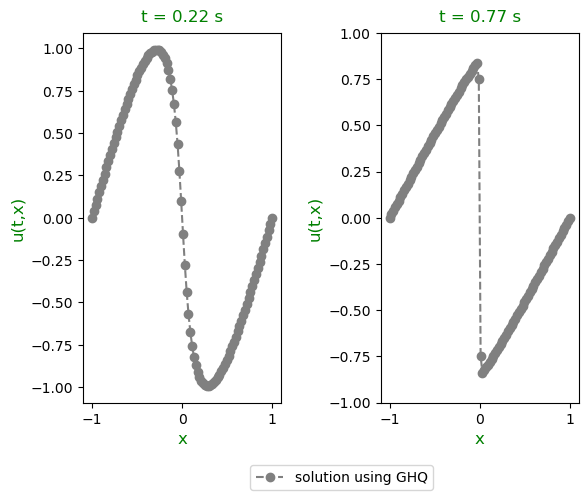

In [150]:
font = {'size': 'large', 'color': 'green'}
gs = gridspec.GridSpec(1, 2, wspace=.5)

ax = plt.subplot(gs[0, 0])
ax.plot(vx2, vu2[22, :], "--o", color="gray", label="solution using GHQ")
ax.set_title(f"t = {vt2[22]} s", verticalalignment='bottom', **font)
ax.set_xlabel('x', **font)
ax.set_ylabel('u(t,x)', **font)

ax = plt.subplot(gs[0, 1])
ax.plot(vx2, vu2[77, :], "--o", color="gray", label="solution using GHQ")
ax.set_title(f"t = {vt2[77]} s", verticalalignment='bottom', **font)
ax.set_xlabel('x', **font)
ax.set_ylabel('u(t,x)', **font)
ax.set_ylim([-1, 1])

ax.legend(bbox_to_anchor=(0.3, -0.15), ncol=2)
plt.show()

## Comparison of PCHIP and GHQ curves

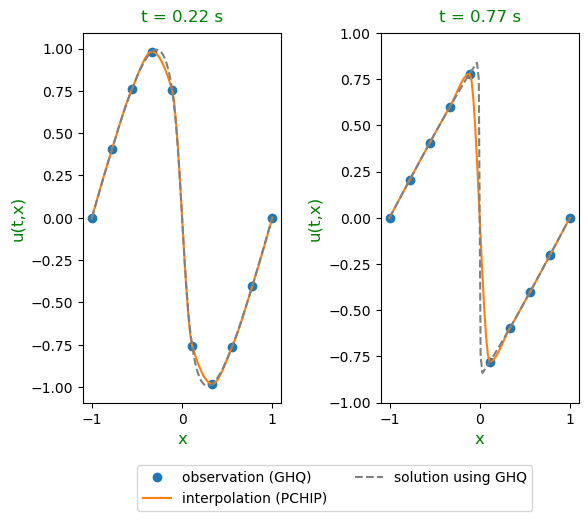

In [151]:
font = {'size': 'large', 'color': 'green'}
gs = gridspec.GridSpec(1, 2, wspace=.5)

ax = plt.subplot(gs[0, 0])
plt.plot(vx, vu[2, :], "o", label="observation (GHQ)")
plt.plot(xq, yq, label="interpolation (PCHIP)")
plt.plot(vx2, vu2[22, :], "--", color="gray", label="solution using GHQ")
ax.set_title(f"t = {vt[2]} s", verticalalignment='bottom', **font)
ax.set_xlabel('x', **font)
ax.set_ylabel('u(t,x)', **font)

ax = plt.subplot(gs[0, 1])
plt.plot(vx, vu[7, :], "o", label="observation (GHQ)")
plt.plot(xq2, yq2, label="interpolation (PCHIP)")
plt.plot(vx2, vu2[77, :], "--", color="gray", label="solution using GHQ")
ax.set_title(f"t = {vt[7]} s", verticalalignment='bottom', **font)
ax.set_xlabel('x', **font)
ax.set_ylabel('u(t,x)', **font)
ax.set_ylim([-1, 1])

ax.legend(bbox_to_anchor=(0.8, -0.15), ncol=2)
plt.show()

## Conclusion

This work compared the PCHIP interpolation method with the Gaussian quadrature method, using the solution of the 1D Burgers equation as a toy problem. The Gauss-Hermite quadrature method was used both to generate the points that were interpolated and to generate the solution that is compared with PCHIP.

The result shows that there is a certain special deviation near the sharp edges of curves at local maxima or minima. However, the PCHIP method generally showed good performance to interpolate the selected toy problem.

## References

[1] ROBERTS, T. W. [Non-oscillatory interpolation for the Semi-Lagrangian scheme](https://www.reading.ac.uk/maths-and-stats/-/media/project/uor-main/schools-departments/maths/documents/tomos-roberts.pdf). 2009.

[2] BASDEVANT, C.; et al. Spectral and finite difference solutions of the Burgers equation. Computers & fluids 14 (1986) 23–41.

[3] RAISSI, M.; et al. Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations. 2017. DOI 10.48550/arXiv.1711.10561

[4] Fritsch, F. N., & Carlson, R. E. (1980). Monotone Piecewise Cubic Interpolation. SIAM Journal on Numerical Analysis, 17(2), Article 2.

[5] Kahaner, D., Moler, C. B., & Nash, S. (1988). Numerical Methods and Software. Prentice Hall.

## Links of interest

-  Cleve Moler. Splines and Pchips. 2012. https://blogs.mathworks.com/cleve/2012/07/16/splines-and-pchips/